In [1]:
# Import dependencies
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.metrics import balanced_accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler


In [2]:
# Read in CSV file
car_df = pd.read_csv('car_price_prediction_data.csv')

In [3]:
# Check column information
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-null  object

In [4]:
# Preview five rows
car_df.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [5]:
# Check how many unique models are in dataset (1590)
print(len(car_df['Model'].unique()))

1590


In [6]:
# Check value distribution for some catagorical columns
columns_to_check = ['Category', 'Leather interior', 'Fuel type', 'Cylinders', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color', 'Airbags']

for column in columns_to_check:
    print(f"{column}:")
    print(car_df[column].value_counts() )
    print('-'*50)

Category:
Sedan          8736
Jeep           5473
Hatchback      2847
Minivan         647
Coupe           532
Universal       364
Microbus        306
Goods wagon     233
Pickup           52
Cabriolet        36
Limousine        11
Name: Category, dtype: int64
--------------------------------------------------
Leather interior:
Yes    13954
No      5283
Name: Leather interior, dtype: int64
--------------------------------------------------
Fuel type:
Petrol            10150
Diesel             4036
Hybrid             3578
LPG                 892
CNG                 494
Plug-in Hybrid       86
Hydrogen              1
Name: Fuel type, dtype: int64
--------------------------------------------------
Cylinders:
4.0     14367
6.0      3462
8.0       991
5.0       169
3.0       107
2.0        42
1.0        38
12.0       38
10.0       12
16.0        5
7.0         4
9.0         1
14.0        1
Name: Cylinders, dtype: int64
--------------------------------------------------
Gear box type:
Automatic

In [7]:
# 1. Remove ID column
car_df = car_df.drop(columns='ID')

In [8]:
# 2. Replace "-" with "0" in the 'Levy' column, convert to int
car_df['Levy'] = (car_df['Levy'].replace('-','0')).astype(int)

In [9]:
# 3. Combine 'Manufacturer' and 'Model' columns
car_df['Make model'] = car_df['Manufacturer'] + ' ' + car_df['Model']
car_df = car_df.drop(columns=['Manufacturer', 'Model'])

In [10]:
# 4. Convert 'Mileage' column to int, then convert from km to mi
car_df['Mileage'] = car_df['Mileage'].str.replace(' km', '', regex=False).astype(int)

miles_per_km = 0.621371
car_df['Mileage (mi)'] = car_df['Mileage']*miles_per_km
car_df['Mileage (mi)'] = car_df['Mileage (mi)'].round(0).astype(int)

car_df = car_df.drop(columns='Mileage')

In [11]:
# 5. Drop 'Doors' and 'Wheel' column since they are heavily skewed in one direction (see value counts above)
car_df = car_df.drop(columns=['Doors', 'Wheel'])

In [12]:
car_df.head()

,Price,Levy,Prod. year,Category,Leather interior,Fuel type,Engine volume,Cylinders,Gear box type,Drive wheels,Color,Airbags,Make model,Mileage (mi)
0,13328,1399,2010,Jeep,Yes,Hybrid,3.5,6.0,Automatic,4x4,Silver,12,LEXUS RX 450,115578
1,16621,1018,2011,Jeep,No,Petrol,3,6.0,Tiptronic,4x4,Black,8,CHEVROLET Equinox,119303
2,8467,0,2006,Hatchback,No,Petrol,1.3,4.0,Variator,Front,Black,2,HONDA FIT,124274
3,3607,862,2011,Jeep,Yes,Hybrid,2.5,4.0,Automatic,4x4,White,0,FORD Escape,104991
4,11726,446,2014,Hatchback,Yes,Petrol,1.3,4.0,Automatic,Front,Silver,4,HONDA FIT,57105


<Axes: >

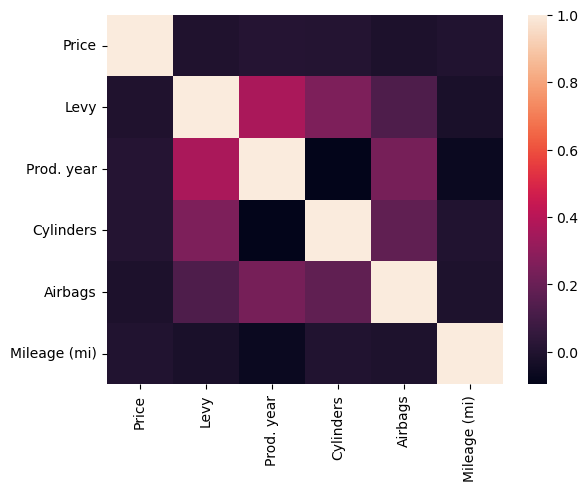

In [13]:
# check correlations of numeric data
# isolate numeric data
car_numeric_df = car_df.select_dtypes(include=['number'])

# calculate correlation matrix
corr_matrix = car_numeric_df.corr()

# create heatmap
sns.heatmap(corr_matrix)

In [14]:
# Strip 'Price' column out for 'X'
X = car_df.drop(columns='Price')

# Set y to 'Price' column
y = car_df['Price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.describe()

,Levy,Prod. year,Cylinders,Airbags,Mileage (mi)
count,14427.000000,14427.000000,14427.000000,14427.000000,1.442700e+04
mean,633.427878,2010.960006,4.582034,6.569211,9.972700e+05
std,554.336687,5.648036,1.200180,4.328991,3.142235e+07
min,0.000000,1939.000000,1.000000,0.000000,0.000000e+00
25%,0.000000,2009.000000,4.000000,4.000000,4.349600e+04
50%,642.000000,2012.000000,4.000000,6.000000,7.791100e+04
75%,917.000000,2015.000000,4.000000,12.000000,1.174390e+05
max,11706.000000,2020.000000,16.000000,16.000000,1.334384e+09


In [15]:
# Check for null values
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14427 entries, 13330 to 15795
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Levy              14427 non-null  int32  
 1   Prod. year        14427 non-null  int64  
 2   Category          14427 non-null  object 
 3   Leather interior  14427 non-null  object 
 4   Fuel type         14427 non-null  object 
 5   Engine volume     14427 non-null  object 
 6   Cylinders         14427 non-null  float64
 7   Gear box type     14427 non-null  object 
 8   Drive wheels      14427 non-null  object 
 9   Color             14427 non-null  object 
 10  Airbags           14427 non-null  int64  
 11  Make model        14427 non-null  object 
 12  Mileage (mi)      14427 non-null  int32  
dtypes: float64(1), int32(2), int64(2), object(8)
memory usage: 1.4+ MB


In [16]:
# Create an instance of OneHotEncoder()
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ohe.set_output(transform="pandas")

# Create a variable containing all columns to encode
columns_to_encode = ['Category', 
                'Leather interior', 
                'Fuel type', 
                'Engine volume', 
                'Gear box type',
                'Drive wheels',
                'Make model',
                'Color']

# Fit the encoder to the data
ohe.fit(X_train[columns_to_encode])



OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [17]:
# Transform the data
X_train_ohe = ohe.transform(X_train[columns_to_encode]).reset_index()
X_test_ohe = ohe.transform(X_test[columns_to_encode]).reset_index()

# Show output for X_train
X_train_ohe

,index,Category_Cabriolet,Category_Coupe,Category_Goods wagon,Category_Hatchback,Category_Jeep,Category_Limousine,Category_Microbus,Category_Minivan,Category_Pickup,...,Color_Green,Color_Grey,Color_Orange,Color_Pink,Color_Purple,Color_Red,Color_Silver,Color_Sky blue,Color_White,Color_Yellow
0,13330,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7499,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,7969,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,3991,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,3447,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14422,11284,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
14423,11964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
14424,5390,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
14425,860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [18]:
# Show output for X_test
X_test_ohe

,index,Category_Cabriolet,Category_Coupe,Category_Goods wagon,Category_Hatchback,Category_Jeep,Category_Limousine,Category_Microbus,Category_Minivan,Category_Pickup,...,Color_Green,Color_Grey,Color_Orange,Color_Pink,Color_Purple,Color_Red,Color_Silver,Color_Sky blue,Color_White,Color_Yellow
0,736,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,8674,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,5971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1957,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11075,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4805,18231,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4806,1082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4807,6206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4808,9124,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [19]:
# Get new feature names
ohe.get_feature_names_out()

array(['Category_Cabriolet', 'Category_Coupe', 'Category_Goods wagon',
       ..., 'Color_Sky blue', 'Color_White', 'Color_Yellow'], dtype=object)

In [20]:
# isolate numeric data for X_Train
X_train_numeric_df = X_train.select_dtypes(include=['number'])
X_train_numeric_df.head()

,Levy,Prod. year,Cylinders,Airbags,Mileage (mi)
13330,0,2015,12.0,10,41010
7499,706,2011,4.0,4,61293
7969,0,2012,4.0,10,67108
3991,1080,2014,6.0,12,108120
3447,1017,2017,4.0,12,7438


In [21]:
# isolate numeric data for X_Test
X_test_numeric_df = X_test.select_dtypes(include=['number'])
X_test_numeric_df.head()

,Levy,Prod. year,Cylinders,Airbags,Mileage (mi)
736,259,2014,4.0,10,40389
8674,0,1997,6.0,2,2071
5971,0,1996,8.0,2,132032
1957,639,2014,4.0,4,82491
11075,831,2017,4.0,4,31535


In [23]:
# scale dataset

scaler = StandardScaler()
scaler.fit(X_train_numeric_df)
X_train_numeric_df_scaled = scaler.transform(X_train_numeric_df)
X_test_numeric_df_scaled = scaler.transform(X_test_numeric_df)

In [28]:
# convert scaled data to a datafram and labeling the columns
X_test_numeric_df_scaled = pd.DataFrame(X_test_numeric_df_scaled, columns=['Levy', 'Prod. year', 'Cylinders', 'Airbags','Mileage (mi)'])
X_train_numeric_df_scaled = pd.DataFrame(X_train_numeric_df_scaled, columns=['Levy', 'Prod. year', 'Cylinders', 'Airbags','Mileage (mi)'])

In [29]:
#reset index for upcoming concat
X_test_numeric_df_scaled = X_test_numeric_df_scaled.reset_index()
X_train_numeric_df_scaled = X_train_numeric_df_scaled.reset_index()

In [26]:
# merge the isolated data
joined_X_test = pd.concat([X_test_numeric_df_scaled, X_test_ohe], axis='columns')

In [31]:
# merge the isolated data
joined_X_train = pd.concat([X_train_numeric_df_scaled, X_train_ohe], axis='columns')
joined_X_train

,index,Levy,Prod. year,Cylinders,Airbags,Mileage (mi),index,Category_Cabriolet,Category_Coupe,Category_Goods wagon,...,Color_Green,Color_Grey,Color_Orange,Color_Pink,Color_Purple,Color_Red,Color_Silver,Color_Sky blue,Color_White,Color_Yellow
0,0,-1.142717,0.715317,6.180927,0.792542,-0.030434,13330,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.130922,0.007081,-0.484972,-0.593510,-0.029788,7499,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2,-1.142717,0.184140,-0.484972,0.792542,-0.029603,7969,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,3,0.805625,0.538258,1.181503,1.254560,-0.028298,3991,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4,0.691972,1.069434,-0.484972,1.254560,-0.031502,3447,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14422,14422,0.444821,1.246493,-0.484972,-0.593510,-0.031502,11284,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
14423,14423,-0.044068,1.246493,-0.484972,1.254560,-0.031045,11964,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
14424,14424,0.507962,0.538258,1.181503,-1.517545,-0.029549,5390,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
14425,14425,-1.142717,-1.055272,1.181503,1.254560,-0.028535,860,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [32]:
# Create the model (Linear Regression)
model_lr = LinearRegression()

#fit the model to the training data
model_lr.fit(joined_X_train, y_train)

LinearRegression()

In [33]:
# Evaluate the Linear Regression model
predicted_lr = model_lr.predict(joined_X_test)

In [34]:
# Score the prediction with mse and r2
mse_lr = mean_squared_error(y_test, predicted_lr)
r2_lr = r2_score(y_test, predicted_lr)

print(f"mean squared error (MSE): {mse_lr}")
print(f"R-squared (R2): {r2_lr}")

mean squared error (MSE): 2029189265.5295234
R-squared (R2): -5.553708141830893


In [ ]:
# Create the Model (Random Forest)
model_rf = RandomForestClassifier(n_estimators=128, random_state=78)

In [ ]:
# Fit the model
model_rf = model_rf.fit(joined_X_train, y_train)

In [ ]:
# Make predictions using the testing data
predicted_rf = model_rf.predict(joined_X_test)

In [ ]:
# Calculate the accuracy score and display the results
acc_score_rf = accuracy_score(y_test, predicted_rf)
print(f"Accuracy Score : {acc_score_rf}")

In [ ]:
# Extra Trees Classifer
model_etc = ExtraTreesClassifier(random_state=42).fit(joined_X_train, y_train)

In [ ]:
# Print the training and testing scores
print(f"Training Score : {model_etc.score(joined_X_train, y_train)}")
print(f"Testing Score : {model_etc.score(joined_X_test, y_test)}")

In [ ]:
# Linear Regression Mean Squared: 2020819078.104065
# Linear Regression R2: -5.5
# Random Forrest Accuracy: .25
# Extra Trees Training: .98
# Extra Trees Testing: .24